In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from strategy import *

%matplotlib inline

bt version :  (0, 2, 10)


In [2]:
# 투자자산
tickers = ['TQQQ','TMF']
safe_ticker = ['BIL']
# 월초 리밸런싱
run_on_end_of_period = False
# 지연시간 1일, 하루전 종가 기준으로 리밸런싱
lag = 1

In [3]:
data = yf.download(tickers+safe_ticker, end='2022-12-31')['Adj Close']
data = data[tickers+safe_ticker]
for c in data.columns:
    print(c, data[c].first_valid_index())
assets = data.dropna().copy()
    
start_day = assets.index.min()# + pd.DateOffset(months=12) - pd.DateOffset(days=1)
print('asset \n', assets)
print('start day : ', start_day)

[*********************100%***********************]  3 of 3 completed
TQQQ 2010-02-11 00:00:00
TMF 2009-04-16 00:00:00
BIL 2007-05-30 00:00:00
asset 
                  TQQQ        TMF        BIL
Date                                       
2010-02-11   0.431471   6.695424  86.560020
2010-02-12   0.433238   6.771189  86.560020
2010-02-16   0.450019   6.831800  86.560020
2010-02-17   0.457656   6.613164  86.503418
2010-02-18   0.466332   6.500600  86.541161
...               ...        ...        ...
2022-12-06  20.820000   9.590000  91.480003
2022-12-07  20.570000  10.230000  91.480003
2022-12-08  21.299999  10.160000  91.540001
2022-12-09  20.889999   9.380000  91.529999
2022-12-12  21.650000   9.460000  91.540001

[3232 rows x 3 columns]
start day :  2010-02-11 00:00:00


In [4]:
usdkrw = yf.download('KRW=X')['Adj Close']
print('usdkrw \n', usdkrw)

assets_krw = pd.merge(data, usdkrw, on='Date', how='outer').sort_values('Date')
print('data_krw \n', assets_krw)

start_day = assets_krw[assets_krw.columns[0]].first_valid_index()
for c in assets_krw.columns:
    if start_day < assets_krw[c].first_valid_index():
        start_day = assets_krw[c].first_valid_index()
    print(c, assets_krw[c].first_valid_index())
print('start_day : ', start_day)
    
assets_krw = assets_krw[start_day:].fillna(method='ffill')
assets_krw.rename(columns={'Adj Close':'krw/usd'}, inplace=True)

for i in range(0, len(assets_krw.columns) - 1):
    assets_krw[assets_krw.columns[i]] = assets_krw[assets_krw.columns[i]] * assets_krw['krw/usd']
print('assets_krw \n', assets_krw)

[*********************100%***********************]  1 of 1 completed
usdkrw 
 Date
2003-12-01    1198.400024
2003-12-02    1195.000000
2003-12-03    1192.500000
2003-12-04    1190.099976
2003-12-05    1184.699951
                 ...     
2022-12-07    1319.709961
2022-12-08    1314.099976
2022-12-09    1316.630005
2022-12-12    1303.170044
2022-12-13    1300.599976
Name: Adj Close, Length: 4936, dtype: float64
data_krw 
                  TQQQ    TMF        BIL    Adj Close
Date                                                
2003-12-01        NaN    NaN        NaN  1198.400024
2003-12-02        NaN    NaN        NaN  1195.000000
2003-12-03        NaN    NaN        NaN  1192.500000
2003-12-04        NaN    NaN        NaN  1190.099976
2003-12-05        NaN    NaN        NaN  1184.699951
...               ...    ...        ...          ...
2022-12-07  20.570000  10.23  91.480003  1319.709961
2022-12-08  21.299999  10.16  91.540001  1314.099976
2022-12-09  20.889999   9.38  91.529999  131

In [5]:
# 매수&보유 백테스트
def long_only_ew(assets, start_day, name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [6]:
# 벤치마크 수익율
bm = long_only_ew(assets[tickers[0]].to_frame(), start_day, 'benchmark({})'.format(tickers[0]))
bm2 = long_only_ew(assets[tickers[1]].to_frame(), start_day, 'benchmark({})'.format(tickers[1]))

bm_report = bt.run(bm)
bm2_report = bt.run(bm2)

Stat                 benchmark(TQQQ)
-------------------  -----------------
Start                2010-02-11
End                  2022-12-12
Risk-free rate       0.00%

Total Return         4917.72%
Daily Sharpe         0.81
Daily Sortino        1.27
CAGR                 35.68%
Max Drawdown         -80.64%
Calmar Ratio         0.44

MTD                  -8.11%
3m                   -30.00%
6m                   -19.19%
YTD                  -73.97%
1Y                   -74.14%
3Y (ann.)            3.06%
5Y (ann.)            13.51%
10Y (ann.)           34.78%
Since Incep. (ann.)  35.68%

Daily Sharpe         0.81
Daily Sortino        1.27
Daily Mean (ann.)    49.70%
Daily Vol (ann.)     61.42%
Daily Skew           -0.39
Daily Kurt           6.25
Best Day             26.99%
Worst Day            -34.47%

Monthly Sharpe       0.83
Monthly Sortino      1.59
Monthly Mean (ann.)  45.07%
Monthly Vol (ann.)   54.35%
Monthly Skew         -0.10
Monthly Kurt         0.20
Best Month           46.45%
Wo

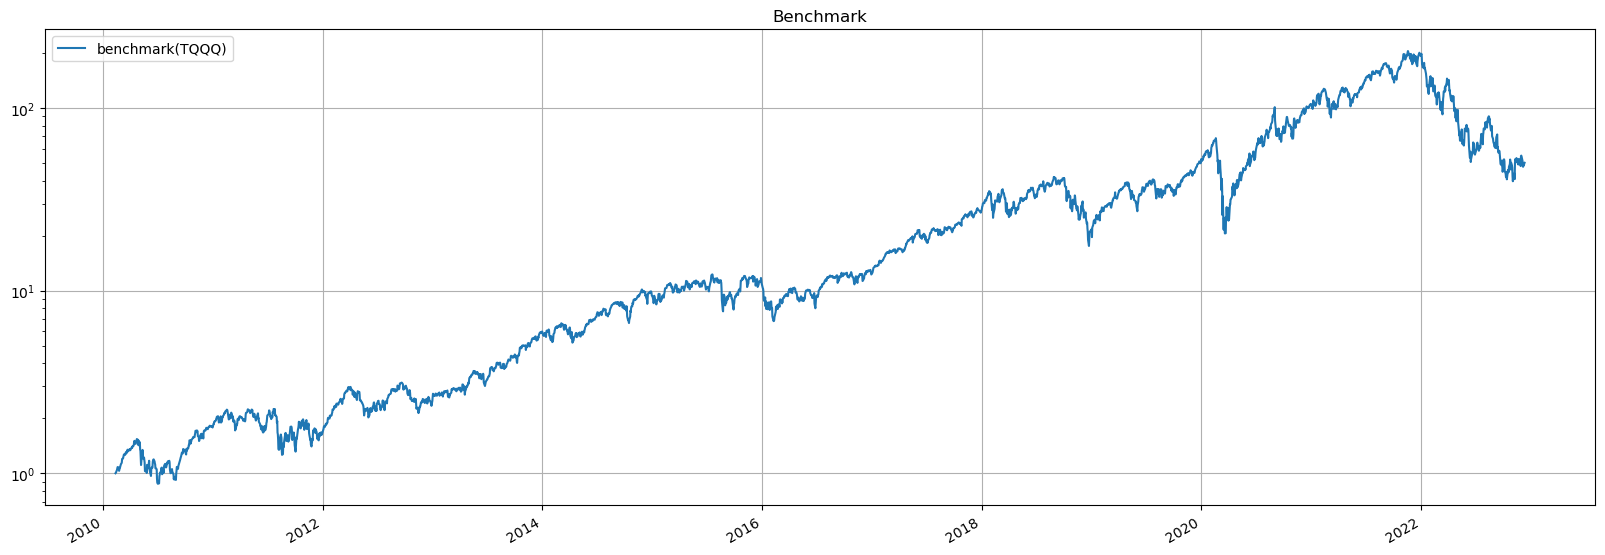

In [7]:
bm_report.prices[start_day:].rebase(1).plot(figsize=(20,7), grid=True, logy=True, title="Benchmark")
bm_report.prices[start_day:].calc_stats().display()

Stat                 benchmark(TMF)
-------------------  ----------------
Start                2010-02-11
End                  2022-12-12
Risk-free rate       0.00%

Total Return         41.29%
Daily Sharpe         0.28
Daily Sortino        0.47
CAGR                 2.73%
Max Drawdown         -87.19%
Calmar Ratio         0.03

MTD                  11.95%
3m                   -5.72%
6m                   -22.82%
YTD                  -66.16%
1Y                   -66.70%
3Y (ann.)            -28.30%
5Y (ann.)            -14.08%
10Y (ann.)           -5.72%
Since Incep. (ann.)  2.73%

Daily Sharpe         0.28
Daily Sortino        0.47
Daily Mean (ann.)    12.74%
Daily Vol (ann.)     44.78%
Daily Skew           0.01
Daily Kurt           3.74
Best Day             20.36%
Worst Day            -18.14%

Monthly Sharpe       0.25
Monthly Sortino      0.51
Monthly Mean (ann.)  10.23%
Monthly Vol (ann.)   40.86%
Monthly Skew         0.59
Monthly Kurt         0.71
Best Month           41.35%
Worst Mo

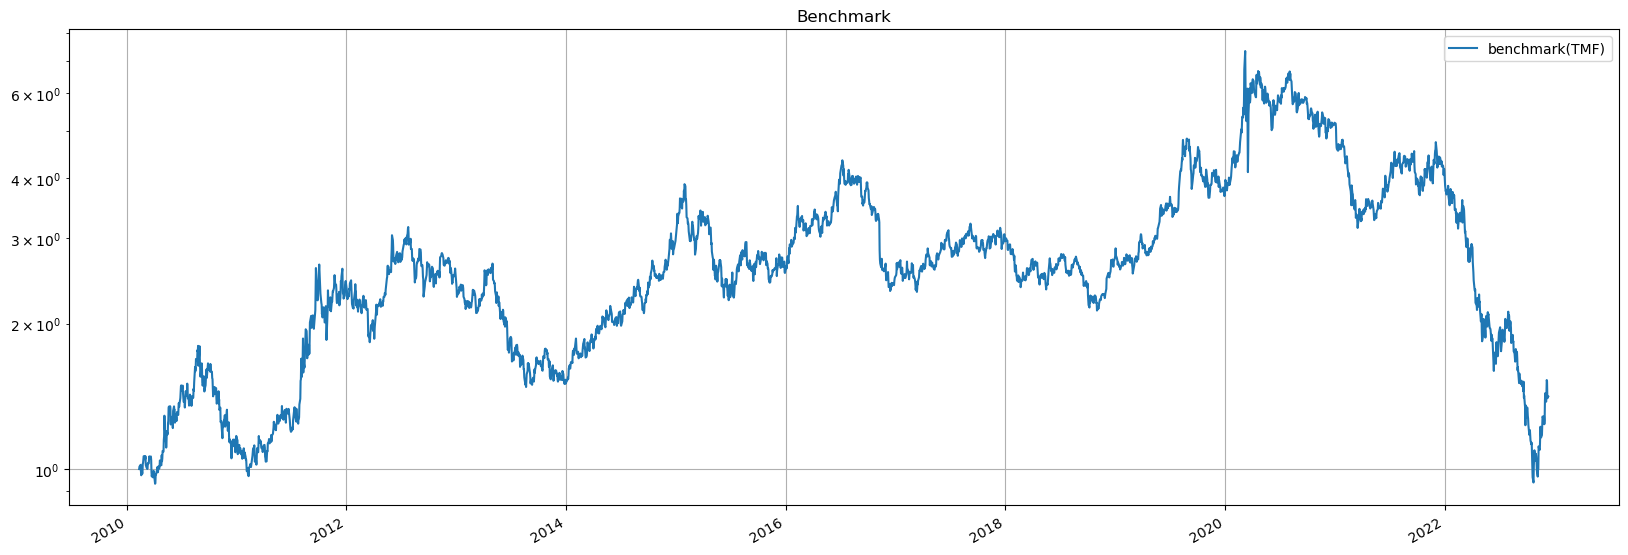

In [8]:
bm2_report.prices[start_day:].rebase(1).plot(figsize=(20,7), grid=True, logy=True, title="Benchmark")
bm2_report.prices[start_day:].calc_stats().display()

In [9]:
bm_k = long_only_ew(assets_krw[tickers[0]].to_frame(), start_day, 'benchmark({}_krw)'.format(tickers[0]))
bm2_k = long_only_ew(assets_krw[tickers[1]].to_frame(), start_day, 'benchmark({}_krw)'.format(tickers[1]))

bm_k_report = bt.run(bm_k)
bm2_k_report = bt.run(bm2_k)

Stat                 benchmark(TQQQ_krw)
-------------------  ---------------------
Start                2010-02-11
End                  2022-12-13
Risk-free rate       0.00%

Total Return         5562.01%
Daily Sharpe         0.81
Daily Sortino        1.28
CAGR                 36.95%
Max Drawdown         -76.92%
Calmar Ratio         0.48

MTD                  -9.82%
3m                   -20.80%
6m                   -4.56%
YTD                  -71.55%
1Y                   -70.20%
3Y (ann.)            6.45%
5Y (ann.)            17.44%
10Y (ann.)           37.72%
Since Incep. (ann.)  36.95%

Daily Sharpe         0.81
Daily Sortino        1.28
Daily Mean (ann.)    49.51%
Daily Vol (ann.)     61.44%
Daily Skew           -0.30
Daily Kurt           6.49
Best Day             29.19%
Worst Day            -34.42%

Monthly Sharpe       0.87
Monthly Sortino      1.66
Monthly Mean (ann.)  44.13%
Monthly Vol (ann.)   50.85%
Monthly Skew         -0.14
Monthly Kurt         0.15
Best Month           45

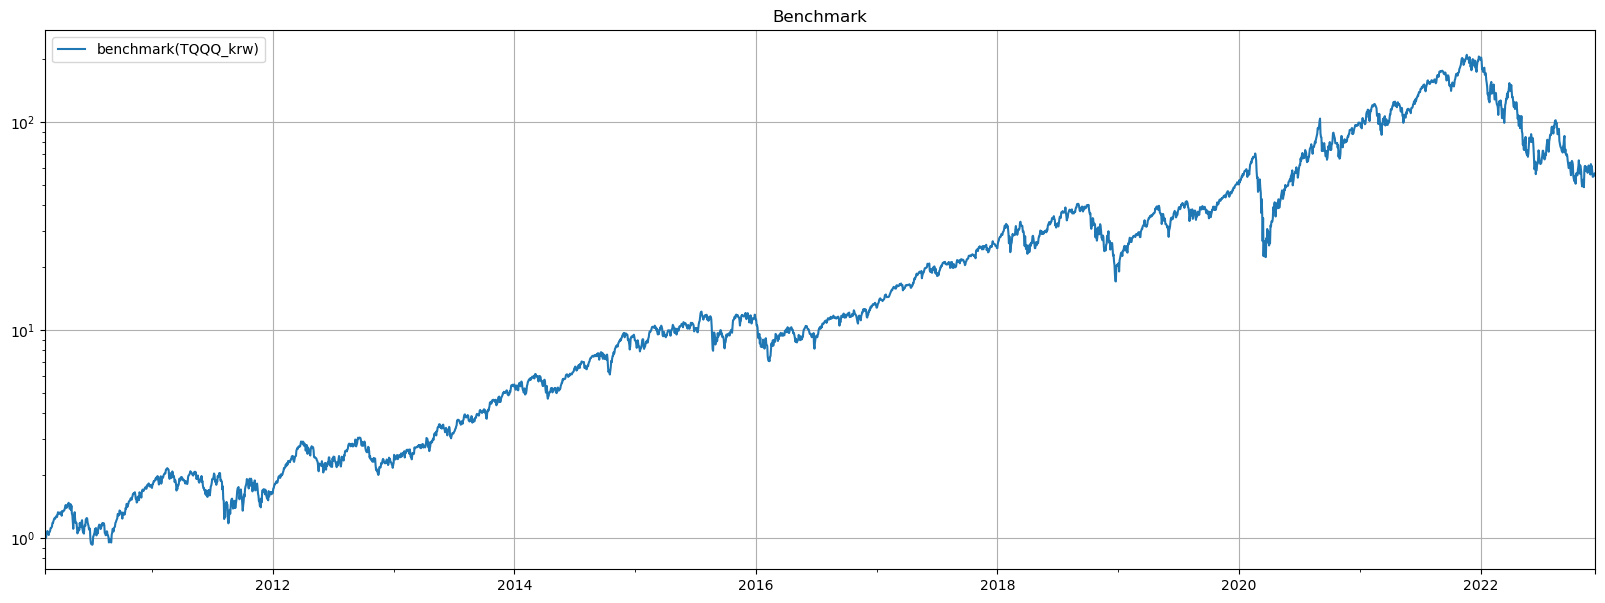

In [10]:
bm_k_report.prices[start_day:].rebase(1).plot(figsize=(20,7), grid=True, logy=True, title="Benchmark")
bm_k_report.prices[start_day:].calc_stats().display()

Stat                 benchmark(TMF_krw)
-------------------  --------------------
Start                2010-02-11
End                  2022-12-13
Risk-free rate       0.00%

Total Return         59.43%
Daily Sharpe         0.30
Daily Sortino        0.52
CAGR                 3.70%
Max Drawdown         -84.60%
Calmar Ratio         0.04

MTD                  9.86%
3m                   -11.40%
6m                   -13.24%
YTD                  -63.01%
1Y                   -64.82%
3Y (ann.)            -26.51%
5Y (ann.)            -11.39%
10Y (ann.)           -3.88%
Since Incep. (ann.)  3.70%

Daily Sharpe         0.30
Daily Sortino        0.52
Daily Mean (ann.)    13.92%
Daily Vol (ann.)     45.63%
Daily Skew           0.12
Daily Kurt           3.48
Best Day             20.51%
Worst Day            -17.75%

Monthly Sharpe       0.27
Monthly Sortino      0.61
Monthly Mean (ann.)  11.91%
Monthly Vol (ann.)   43.57%
Monthly Skew         1.03
Monthly Kurt         1.97
Best Month           55.23%


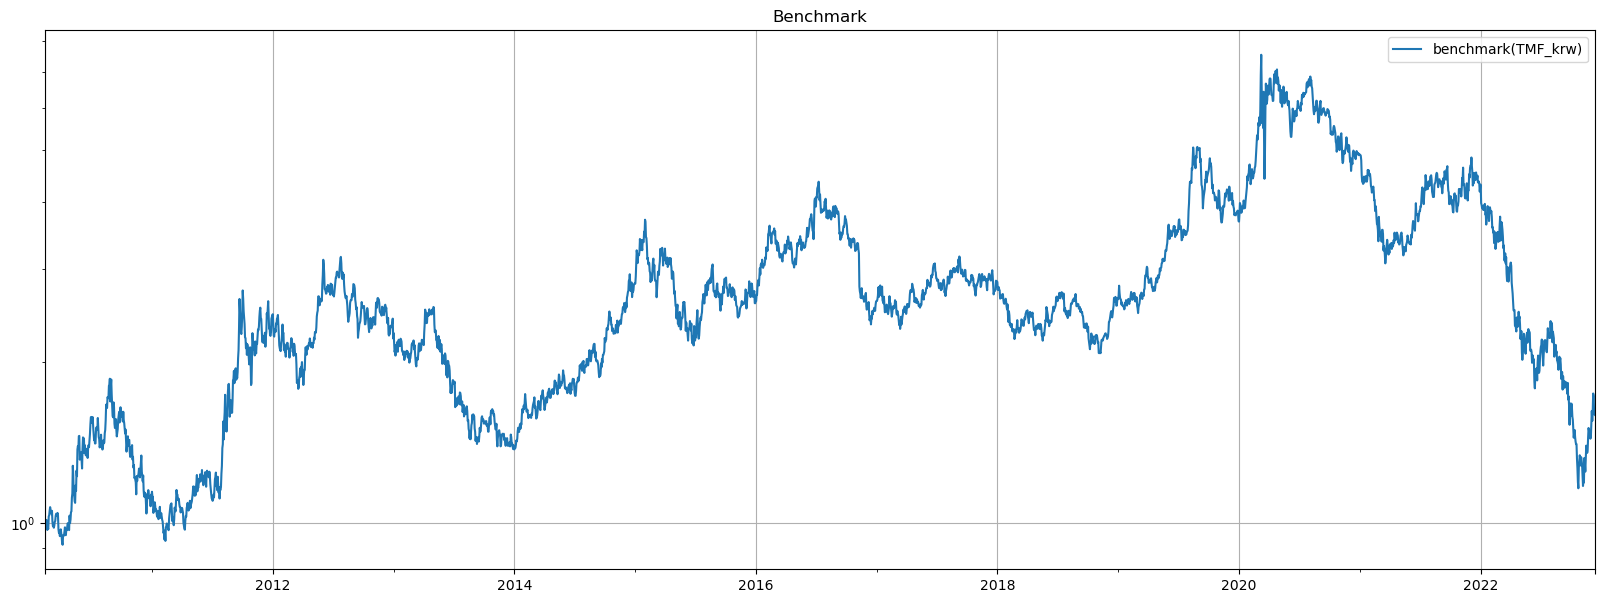

In [11]:
bm2_k_report.prices[start_day:].rebase(1).plot(figsize=(20,7), grid=True, logy=True, title="Benchmark")
bm2_k_report.prices[start_day:].calc_stats().display()

In [12]:
def FixedWeight_BT(assets, start_day, weights, run_on_end_of_period=False, returns=pd.DataFrame(), lag=1, ylookback=12, name='Fixed Weighted'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           #bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           bt.algos.RunQuarterly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           WeighFixed(returns, lag, ylookback, **weights),
                           #bt.algos.PrintTempData(),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),                           
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [13]:
init=9
empty = pd.DataFrame()
fixedWeights = {}
for i in range(0,9):
    weights = {tickers[0]:init/10,tickers[1]:(10-init)/10}
    print(weights)
    fixedWeights[i] = FixedWeight_BT(assets[tickers], start_day, weights, False, empty, 0, 0, name='FW_{}:{}'.format(init,(10-init)))
    init = init - 1
fw_report = bt.run(*fixedWeights.values())

{'TQQQ': 0.9, 'TMF': 0.1}
{'TQQQ': 0.8, 'TMF': 0.2}
{'TQQQ': 0.7, 'TMF': 0.3}
{'TQQQ': 0.6, 'TMF': 0.4}
{'TQQQ': 0.5, 'TMF': 0.5}
{'TQQQ': 0.4, 'TMF': 0.6}
{'TQQQ': 0.3, 'TMF': 0.7}
{'TQQQ': 0.2, 'TMF': 0.8}
{'TQQQ': 0.1, 'TMF': 0.9}


<AxesSubplot:title={'center':'Fixed Weight'}>

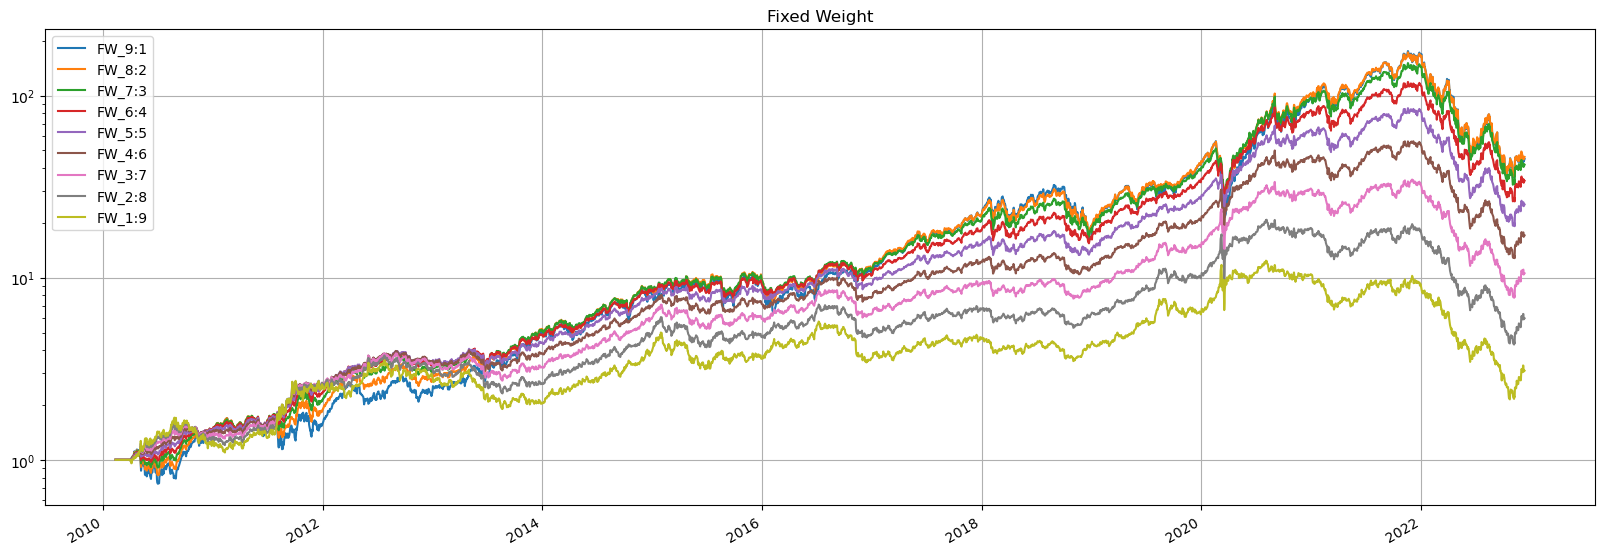

In [14]:
fw_report.prices[start_day:].rebase(1).plot(figsize=(20,7), grid=True, logy=True, title="Fixed Weight")

In [15]:
fw_report.prices[start_day:].calc_stats().display()

Stat                 FW_9:1      FW_8:2      FW_7:3      FW_6:4      FW_5:5      FW_4:6      FW_3:7      FW_2:8      FW_1:9
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11
End                  2022-12-12  2022-12-12  2022-12-12  2022-12-12  2022-12-12  2022-12-12  2022-12-12  2022-12-12  2022-12-12
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         4384.32%    4499.67%    4072.12%    3303.88%    2422.80%    1607.61%    957.59%     498.74%     208.65%
Daily Sharpe         0.83        0.89        0.93        0.96        0.94        0.86        0.73        0.57        0.42
Daily Sortino        1.30        1.40        1.47        1.52        1.49        1.37        1.17        0.93        0.69

In [16]:
fw_report.backtests['FW_4:6'].stats.drawdown_details.sort_values('drawdown').head(20)

,Start,End,Length,drawdown
172,2021-12-08 00:00:00,2022-12-12 00:00:00,369,-0.771818
148,2020-03-10 00:00:00,2020-04-16 00:00:00,37,-0.42308
162,2020-09-03 00:00:00,2021-07-19 00:00:00,319,-0.313768
103,2016-09-07 00:00:00,2017-05-22 00:00:00,257,-0.260686
122,2018-08-31 00:00:00,2019-03-15 00:00:00,196,-0.235271
61,2013-05-03 00:00:00,2014-01-15 00:00:00,257,-0.226742
92,2015-02-03 00:00:00,2016-04-01 00:00:00,423,-0.210197
118,2018-01-29 00:00:00,2018-07-10 00:00:00,162,-0.19136
60,2012-09-04 00:00:00,2013-05-02 00:00:00,240,-0.167005
169,2021-09-16 00:00:00,2021-11-04 00:00:00,49,-0.164103


In [17]:
fw_report.backtests['FW_4:6'].stats.yearly_returns

2010-12-31         NaN
2011-12-31    0.816585
2012-12-31    0.328520
2013-12-31    0.115410
2014-12-31    0.801042
2015-12-31    0.037616
2016-12-31    0.076491
2017-12-31    0.567755
2018-12-31   -0.058306
2019-12-31    0.796129
2020-12-31    1.275369
2021-12-31    0.157536
2022-12-31   -0.684149
Freq: A-DEC, Name: price, dtype: float64

In [18]:
init=9
fixedWeights_krw = {}
for i in range(0,9):
    weights = {tickers[0]:init/10,tickers[1]:(10-init)/10}
    print(weights)
    fixedWeights_krw[i] = FixedWeight_BT(assets_krw[tickers], start_day, weights, False, empty, 0, 0, name='FWK_{}:{}'.format(init,(10-init)))
    init = init - 1
fw_krw_report = bt.run(*fixedWeights_krw.values())

{'TQQQ': 0.9, 'TMF': 0.1}
{'TQQQ': 0.8, 'TMF': 0.2}
{'TQQQ': 0.7, 'TMF': 0.3}
{'TQQQ': 0.6, 'TMF': 0.4}
{'TQQQ': 0.5, 'TMF': 0.5}
{'TQQQ': 0.4, 'TMF': 0.6}
{'TQQQ': 0.3, 'TMF': 0.7}
{'TQQQ': 0.2, 'TMF': 0.8}
{'TQQQ': 0.1, 'TMF': 0.9}


<AxesSubplot:title={'center':'Fixed Weight'}>

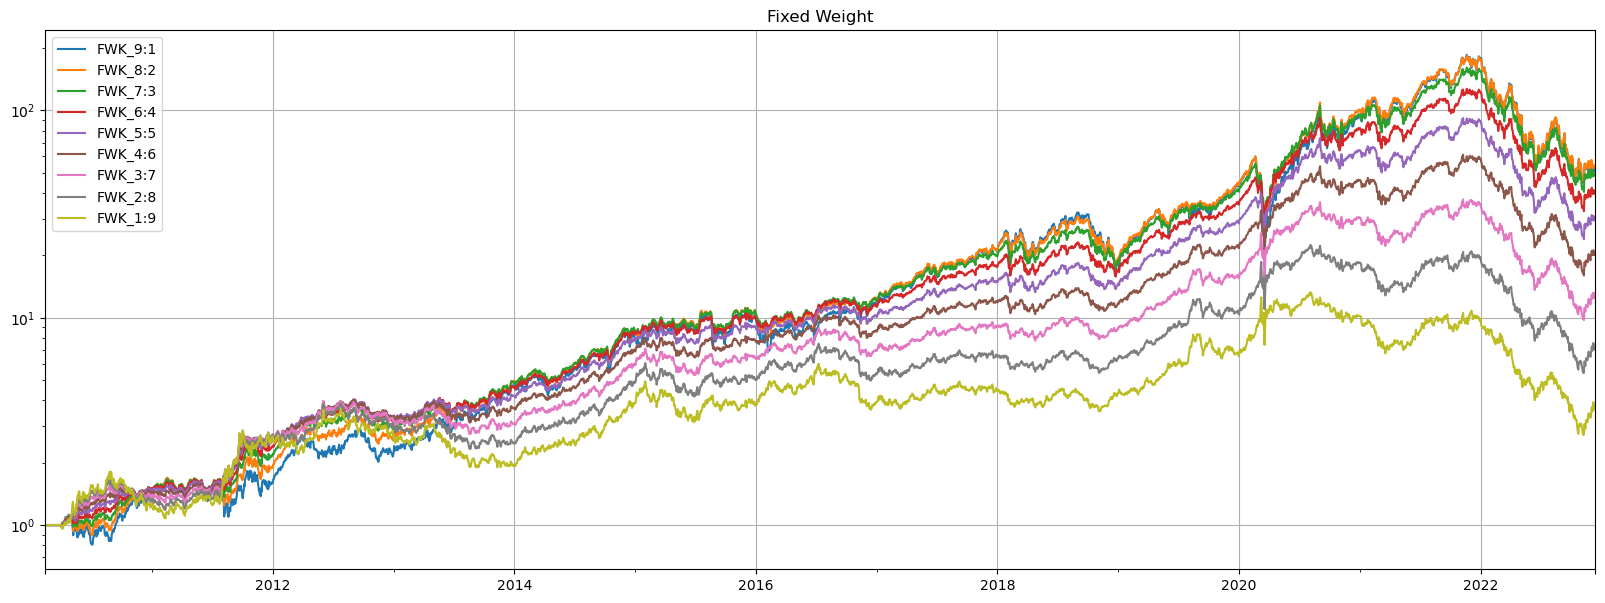

In [19]:
fw_krw_report.prices[start_day:].rebase(1).plot(figsize=(20,7), grid=True, logy=True, title="Fixed Weight")

In [20]:
fw_krw_report.prices[start_day:].calc_stats().display()

Stat                 FWK_9:1     FWK_8:2     FWK_7:3     FWK_6:4     FWK_5:5     FWK_4:6     FWK_3:7     FWK_2:8     FWK_1:9
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11
End                  2022-12-13  2022-12-13  2022-12-13  2022-12-13  2022-12-13  2022-12-13  2022-12-13  2022-12-13  2022-12-13
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         5115.64%    5277.48%    4800.10%    3911.78%    2879.78%    1917.97%    1148.10%    604.07%     260.66%
Daily Sharpe         0.83        0.88        0.93        0.95        0.93        0.85        0.73        0.59        0.44
Daily Sortino        1.32        1.41        1.49        1.53        1.50        1.39        1.20        0.97        0.7

In [21]:
fw_krw_report.backtests['FWK_4:6'].stats.drawdown_details.sort_values('drawdown').head(20)

,Start,End,Length,drawdown
158,2021-11-10 00:00:00,2022-12-13 00:00:00,398,-0.738508
133,2020-03-10 00:00:00,2020-04-15 00:00:00,36,-0.39846
151,2020-09-03 00:00:00,2021-08-03 00:00:00,334,-0.34639
43,2012-09-03 00:00:00,2014-01-23 00:00:00,507,-0.226476
106,2018-09-03 00:00:00,2019-03-12 00:00:00,190,-0.225839
90,2016-08-24 00:00:00,2017-05-19 00:00:00,268,-0.223612
79,2015-02-03 00:00:00,2015-12-01 00:00:00,301,-0.198319
101,2018-01-29 00:00:00,2018-06-18 00:00:00,140,-0.185594
156,2021-09-16 00:00:00,2021-11-04 00:00:00,49,-0.14641
126,2019-09-05 00:00:00,2020-01-03 00:00:00,120,-0.143922


In [22]:
assets_cash = assets[tickers].copy()
assets_cash['cash'] = assets[safe_ticker[0]]
print(assets_cash)

                 TQQQ        TMF       cash
Date                                       
2010-02-11   0.431471   6.695424  86.560020
2010-02-12   0.433238   6.771189  86.560020
2010-02-16   0.450019   6.831800  86.560020
2010-02-17   0.457656   6.613164  86.503418
2010-02-18   0.466332   6.500600  86.541161
...               ...        ...        ...
2022-12-06  20.820000   9.590000  91.480003
2022-12-07  20.570000  10.230000  91.480003
2022-12-08  21.299999  10.160000  91.540001
2022-12-09  20.889999   9.380000  91.529999
2022-12-12  21.650000   9.460000  91.540001

[3232 rows x 3 columns]


In [25]:
init=9
yfixedWeights = {}
for i in range(0,9):
    weights = {tickers[0]:init/10,tickers[1]:(10-init)/10,'cash':0}
    print(weights)
    returns = fw_report.prices['FW_{}:{}'.format(init,(10-init))].rebase(1).to_frame().copy()
    print('returns[FW_{}:{}]\n'.format(init, (10-init)), returns)
    yfixedWeights[i] = FixedWeight_BT(assets_cash, start_day, weights, False, returns, 1, 12, name='yFW_{}:{}'.format(init,(10-init)))
    init = init - 1
yfw_report = bt.run(*yfixedWeights.values())

{'TQQQ': 0.9, 'TMF': 0.1, 'cash': 0}
returns[FW_9:1]
                FW_9:1
2010-02-10   1.000000
2010-02-11   1.000000
2010-02-12   1.000000
2010-02-16   1.000000
2010-02-17   1.000000
...               ...
2022-12-06  43.358710
2022-12-07  43.197737
2022-12-08  44.524510
2022-12-09  43.389112
2022-12-12  44.843223

[3233 rows x 1 columns]
{'TQQQ': 0.8, 'TMF': 0.2, 'cash': 0}
returns[FW_8:2]
                FW_8:2
2010-02-10   1.000000
2010-02-11   1.000000
2010-02-12   1.000000
2010-02-16   1.000000
2010-02-17   1.000000
...               ...
2022-12-06  44.714407
2022-12-07  44.914935
2022-12-08  46.086009
2022-12-09  44.628181
2022-12-12  45.996674

[3233 rows x 1 columns]
{'TQQQ': 0.7, 'TMF': 0.3, 'cash': 0}
returns[FW_7:3]
                FW_7:3
2010-02-10   1.000000
2010-02-11   1.000000
2010-02-12   1.000000
2010-02-16   1.000000
2010-02-17   1.000000
...               ...
2022-12-06  40.775953
2022-12-07  41.289144
2022-12-08  42.179365
2022-12-09  40.591357
2022-12-12  41.721

Stat                 yFW_9:1     yFW_8:2     yFW_7:3     yFW_6:4     yFW_5:5     yFW_4:6     yFW_3:7     yFW_2:8     yFW_1:9
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11
End                  2022-12-12  2022-12-12  2022-12-12  2022-12-12  2022-12-12  2022-12-12  2022-12-12  2022-12-12  2022-12-12
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         1216.38%    2107.00%    2715.79%    2856.04%    2282.63%    1634.38%    917.52%     421.29%     187.17%
Daily Sharpe         0.70        0.85        0.98        1.08        1.09        1.02        0.87        0.64        0.44
Daily Sortino        1.05        1.30        1.52        1.67        1.68        1.58        1.37        1.01        0.6

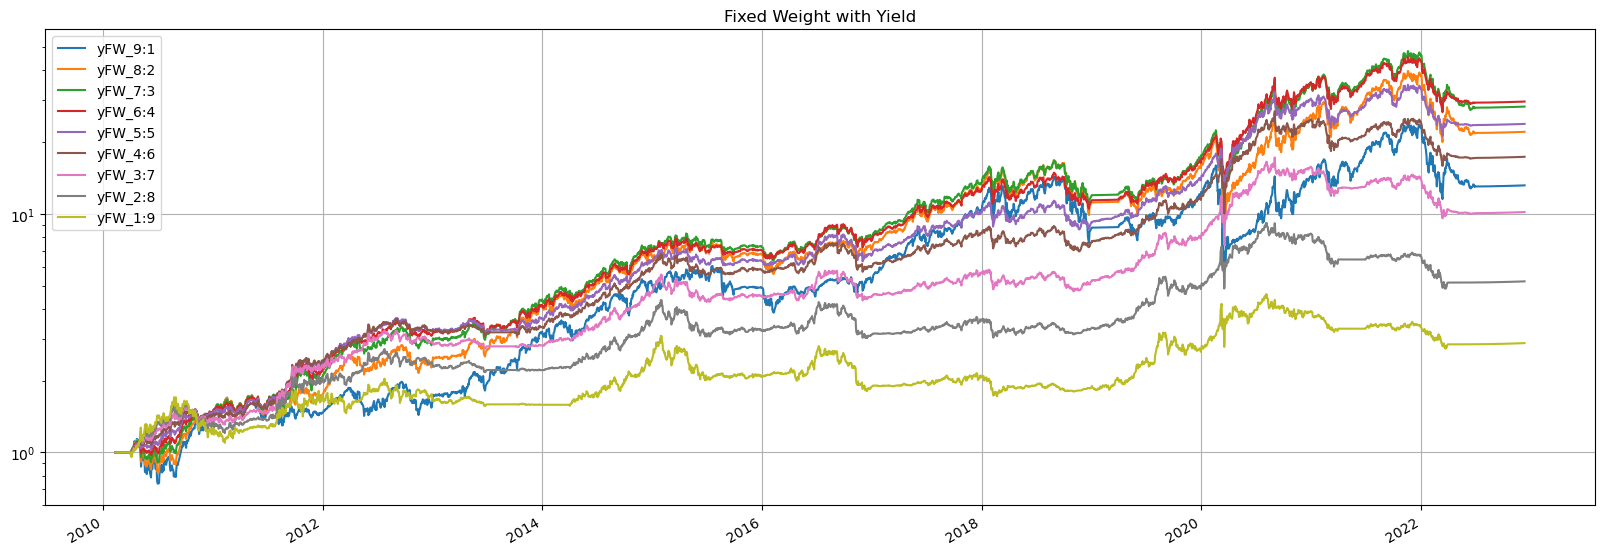

In [26]:
yfw_report.prices[start_day:].rebase(1).plot(figsize=(20,7), grid=True, logy=True, title="Fixed Weight with Yield")
yfw_report.prices[start_day:].calc_stats().display()